# TESLA TIME SERIES LINEAR REGRESSION MODEL

### Purpose


*   build model that predict Tesla's stock price based on historical data.



DATA SOURCE: kaggle (https://www.kaggle.com/datasets/simronw/tesla-stock-data-2024)



In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
from datetime import datetime
import pytz
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


In [2]:
df = pd.read_csv('/content/TESLA.csv')
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
0,0,6/29/10,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,1,6/30/10,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2,7/1/10,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,3,7/2/10,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,4,7/6/10,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [3]:
#The unnamed column is similar to the index column so it will not be useful in our analysis
df.drop(columns=['Unnamed: 0'], inplace=True)

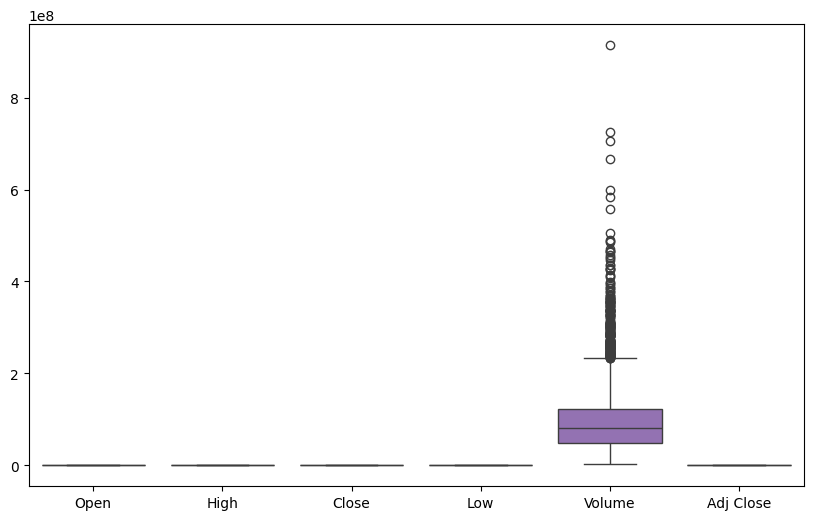

In [4]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['Open', 'High', 'Close', 'Low', 'Volume', 'Adj Close']]);



*   Plotted boxplots to check for outliers.
*   `Open`, `Close`, `High`, `Low`, `Adj Close` have no major outliers or anormalities.
*   `Volume` has huge outliers, these could mean high trading volumes on  specific days.




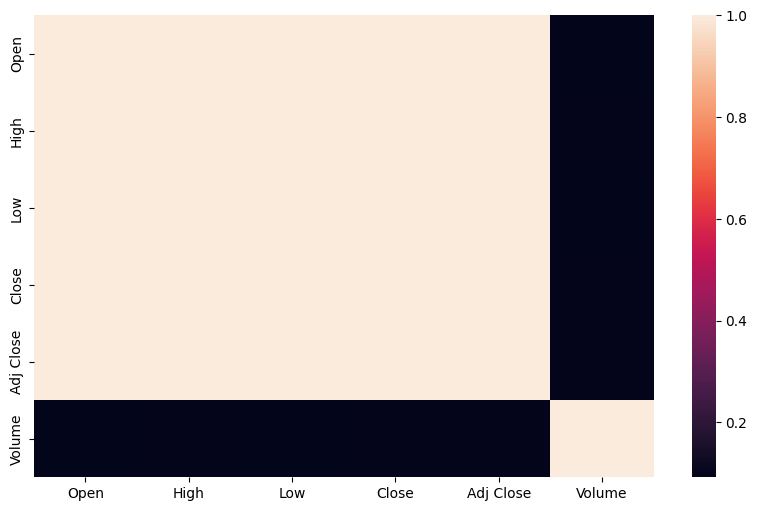

In [5]:
plt.figure(figsize=(10, 6))
corr = df.select_dtypes('number').corr()
sns.heatmap(corr);



*   The columns (`Open`, `Close`, `High`, `Low`, `Adj Close` and `Volume`) are higly correlated when compared to each other.
*   `Volume` compared with other columns show a negative correlation.
*   Since `Volume` has a weak correlation it will not be helpful in building a linear regression model.





<ipython-input-6-a36dd8478135>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


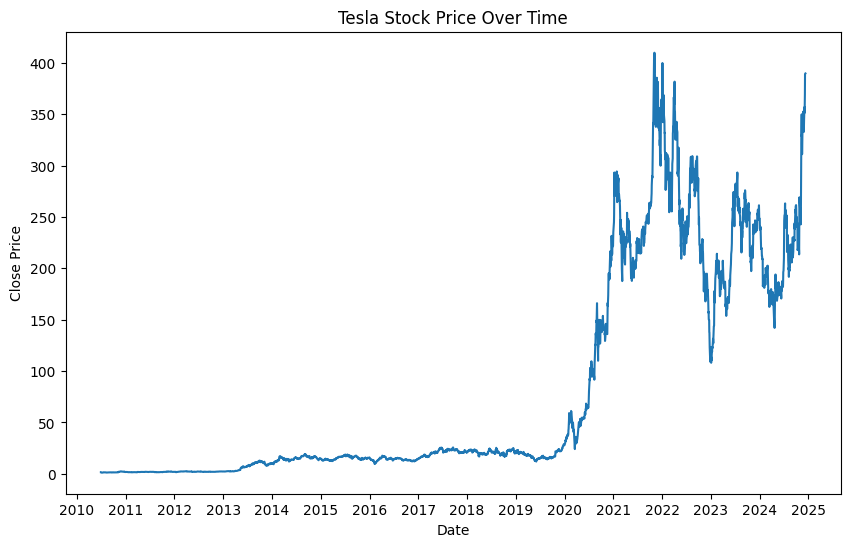

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Tesla Stock Price Over Time');

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show();



*   From the year 2010 to 2019, there is a somewhat steady trend in the price of Tesla Stock.
*   From 2020 to 2024, there is an increase in price
*   Though there is an increase in price, there are flucatuations too.
*   This shows the high levels of volitality.





In [7]:
df = df.set_index('Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [8]:
#plot a rolling 30 day average to smooth out the prices over time
df['Rolling 30'] = df['Adj Close'].rolling(window=30).mean()


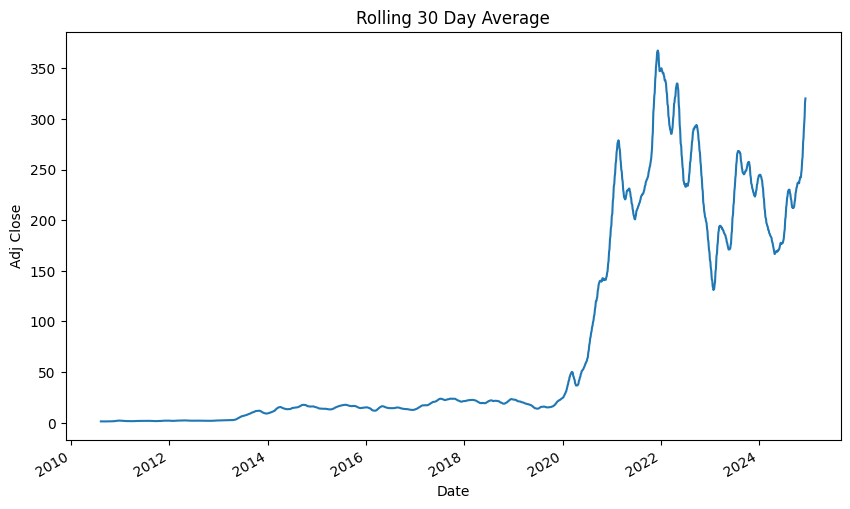

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
df['Adj Close'].rolling(window=30).mean().plot(ax=ax, ylabel='Adj Close', title="Rolling 30 Day Average");

## Model Building



In [10]:
#create a 3 lag columns and shift them by 1, 2, & 3 days respectively
df['Lag 1'] = df['Adj Close'].shift(1)
df['Lag 2'] = df['Adj Close'].shift(2)
df['Lag 3'] = df['Adj Close'].shift(3)
df.dropna().head()

,Open,High,Low,Close,Adj Close,Volume,Rolling 30,Lag 1,Lag 2,Lag 3
Date,,,,,,,,,,
2010-08-10,1.310000,1.310000,1.254667,1.268667,1.268667,19219500,1.336089,1.306667,1.306000,1.363333
2010-08-11,1.246000,1.258667,1.190000,1.193333,1.193333,11964000,1.322778,1.268667,1.306667,1.306000
2010-08-12,1.186667,1.193333,1.159333,1.173333,1.173333,10365000,1.308933,1.193333,1.268667,1.306667
2010-08-13,1.212000,1.230000,1.177333,1.221333,1.221333,9510000,1.300844,1.173333,1.193333,1.268667
2010-08-16,1.230000,1.253333,1.217333,1.252000,1.252000,7287000,1.299911,1.221333,1.173333,1.193333


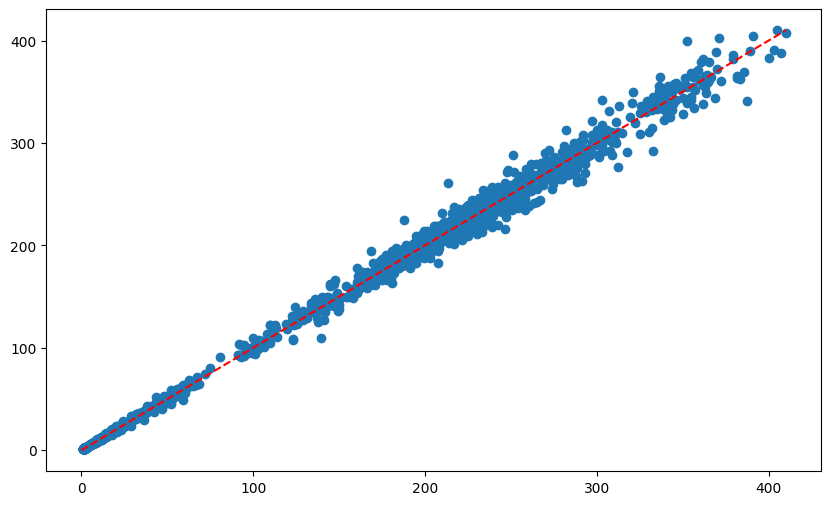

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x=df['Lag 1'], y=df['Adj Close'])
ax.plot([0, 410], [0, 410], linestyle='--', color='red');

In [12]:
#create a dataframe for the specific columns that will be used for the model
df_1 = df[['Adj Close', 'Lag 1']].dropna()
df_1.head()

,Adj Close,Lag 1
Date,,
2010-06-30,1.588667,1.592667
2010-07-01,1.464000,1.588667
2010-07-02,1.280000,1.464000
2010-07-06,1.074000,1.280000
2010-07-07,1.053333,1.074000


In [13]:
df_1.corr()

,Adj Close,Lag 1
Adj Close,1.000000,0.998851
Lag 1,0.998851,1.000000


In [14]:
#Split into feature metrics and target metrics
target = 'Adj Close'
y = df_1[target]
X = df_1.drop(columns=target)

In [15]:
X.head()

,Lag 1
Date,
2010-06-30,1.592667
2010-07-01,1.588667
2010-07-02,1.464000
2010-07-06,1.280000
2010-07-07,1.074000


In [16]:
#divide the data in 2 parts
#80% used to train and 20% for testing
cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

In [17]:
y_mean = y_train.mean()
y_pred = [y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred)

print('Mean Adj Close:', round(y_train.mean(),2))
print('Baseline MAE:', round(mae_baseline,2))

Mean Adj Close: 42.23
Baseline MAE: 49.65


In [18]:
model= LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [19]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))

print('Training MAE:', round(training_mae, 2))
print('Test MAE:', round(test_mae, 2))

Training MAE: 1.15
Test MAE: 6.49




*   Model perform good on the training data and missed by 1.15 units.
*   Model did not perform as good as the training data because it missed by 6.49units.

*   Trained the model again with `Lag 3` and it performed even worse because it missed by just above 11 units.





In [20]:
#create another dataframe to train the model again
df_model = df[['Adj Close', 'Lag 1', 'Lag 2', 'Lag 3']].dropna()


target = 'Adj Close'
y = df_model[target]
X = df_model[['Lag 1', 'Lag 2', 'Lag 3']]

In [21]:
df_model.head()

,Adj Close,Lag 1,Lag 2,Lag 3
Date,,,,
2010-07-02,1.280000,1.464000,1.588667,1.592667
2010-07-06,1.074000,1.280000,1.464000,1.588667
2010-07-07,1.053333,1.074000,1.280000,1.464000
2010-07-08,1.164000,1.053333,1.074000,1.280000
2010-07-09,1.160000,1.164000,1.053333,1.074000


In [22]:
cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

In [23]:
y_mean = y_train.mean()
y_pred = [y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred)

print('Mean Adj Close:', round(y_train.mean(),2))
print('Baseline MAE:', round(mae_baseline,2))

Mean Adj Close: 42.37
Baseline MAE: 49.83


In [24]:
model= LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [25]:
training_mae2 = mean_absolute_error(y_train, model.predict(X_train))
test_mae2 = mean_absolute_error(y_test, model.predict(X_test))

print('Training MAE:', round(training_mae2, 2))
print('Test MAE:', round(test_mae2, 2))

Training MAE: 1.15
Test MAE: 6.49




*   Trained the model again for the 3rd time to see if the model will perform better, but this time around I combined `Lag 1`, `Lag 2`, & `Lag 3`.
*   The results were just the same as the results from my first model which I only used `Lag 1`, at this point it was benefical to use the first model for the linear regression model as it performed better.
*   it’s possible that `Lag 1` already captures most of the predictive power.
*The prices on day -2 and day -3 may be very similar to day -1 especially if the stock moves gradually.
*  So when you add Lag 2 and Lag 3, the model doesn't learn much new.






In [26]:
intercept = model.intercept_.round(2)
coefficient1 = model.coef_.round(2)[0]


print(f'Adj Close = {intercept} + ({coefficient1} * Lag 1)')

Adj Close = 0.05 + (0.97 * Lag 1)


### Results
Adj Close = 0.05 + (0.97 * `Lag 1`)

In [27]:
df_pred_test = pd.DataFrame(
    {
        'y_test': y_test,
        'y_pred': model.predict(X_test)
    }
)
df_pred_test.head()

,y_test,y_pred
Date,,
2022-01-19,331.883331,344.368136
2022-01-20,332.089996,332.928589
2022-01-21,314.633331,332.705285
2022-01-24,310.000000,315.859127
2022-01-25,306.133331,310.758711


In [28]:
#Visualise the predicted results
fig = px.line(df_pred_test, title='Actual vs Predicted', labels={'value': 'Adj Close'})
fig.show()

Visual representation of the Tesla Time Series Linear Regression Model.